_This notebook contains code and comments from Section 4.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 4.4 Case Study: Handwriting Digit Classification
In this case study, we will use scikit-learn’s digits data set to illustrate the effectiveness of AdaBoost. The data set consists of 1797 scanned images of handwritten digits from 0 to 9. Each digit is associated with a unique label, which makes this a 10-class classification problem. There are roughly 180 digits per class.

The digits themselves are represented as 16 x 16 normalized greyscale bitmap images, which when flattened results in a 64-dimensional vector for each handwritten digit. Thus, the training set is of size 1797 (examples) x 64 features. 

In [1]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
X.shape

(1797, 64)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

We can visualize this data set as a snapshot to get an idea of what they look like.

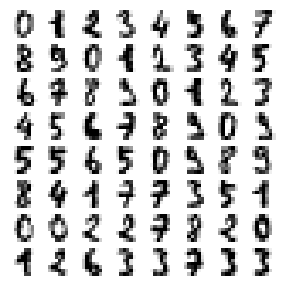

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_img_per_row = 8
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

ax.imshow(img, cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
# ax.set_title('A selection from the 64-dimensional digits dataset')

# plt.savefig('./figures/CH04_F13_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0);
# plt.savefig('./figures/CH04_F13_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0);

---
### 4.4.1	Dimensionality Reduction with t-SNE

While AdaBoost can effectively handle the dimensionality of the digits data set (64 features), we will (rather aggressively) look to reduce the dimensionality to 2. The main reason for this is to be able to visualize the data as well as the models learned by AdaBoost.

We’ll use a nonlinear dimensionality reduction technique known as [t-distributed stochastic neighbor](https://lvdmaaten.github.io/tsne/) embedding or t-SNE. t-SNE is a highly effective pre-processing technique for the digits data set and extracts an effective embedding in a two-dimensional space.

In ``scikit-learn``, the [``manifold.TSNE``](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) package implements t-SNE.

In [4]:
from sklearn.manifold import TSNE
Xemb = TSNE(n_components=2, init='pca').fit_transform(X)

C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


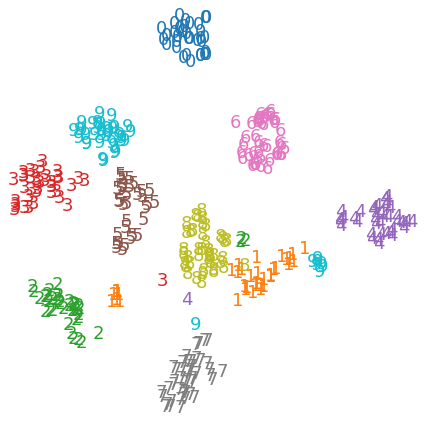

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
xMin, xMax = np.min(Xemb, axis=0), np.max(Xemb, axis=0)
Xemb = (Xemb - xMin) / (xMax - xMin)

for i in range(Xemb.shape[0]):
    if np.random.ranf() < 0.8:
        # Skip some data points so that the image isn't super cluttered
        continue
    plt.text(Xemb[i, 0], Xemb[i, 1], str(y[i]), color=plt.cm.tab10(y[i] / 10.),
             fontdict={'size': 18})

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
fig.tight_layout()

# plt.savefig('./figures/CH04_F14_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH04_F14_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

It is important to hold aside a part of the training data for evaluation and to quantify the predictive performance of our models on future data. We split the lower-dimensional data Xemb and the labels into training and test sets.

Observe the use of ``stratify=y``, to ensure that the ratios of the different digits in train and test sets are identical.

In [6]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(Xemb, y, test_size=0.2, stratify=y, random_state=13)

---
### 4.4.2	Boosting

We will now train an AdaBoost model for this digit classification task. Recall from our earlier discussion that AdaBoost requires us to first decide the type of base estimator. We continue to use decision stumps.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

stump = DecisionTreeClassifier(max_depth=2)
ensemble = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump)

To identify the best combination of ``learning_rate`` and ``n_estimators`` for the ``AdaBoostClassifier``, we will employ a combination of k-fold cross validation and [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search). 

The basic idea is to consider different combinations of ``learning_rate`` and ``n_estimators`` and evaluate what their performance would be like via cross validation. First, we select various parameter values we want to explore.

In [8]:
parameters_to_search = {'n_estimators': [200, 300, 400, 500],
                        'learning_rate': [0.6, 0.8, 1.0]}

Next, we make a scoring function to evaluate the performance of each parameter combination. For this task, we use the balanced accuracy score, which is essentially just the accuracy score weighted by each class. 

In [9]:
from sklearn.metrics import balanced_accuracy_score, make_scorer
scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

Now, we set up and run the grid search to identify the best parameter combination with the [``GridSearchCV``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class. The parameter ``cv=5`` specifies 5-fold cross validation and ``n_jobs=-1`` specifies that the job should use all available cores for parallel processing. 

The final parameter in ``GridSearchCV`` is set to ``refit=True``. This tells GridSearchCV to train a final model using all the available training data using the best parameter combination it has identified.

In [10]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(ensemble, param_grid=parameters_to_search,
                       scoring=scorer, cv=5, n_jobs=-1, refit=True)
search.fit(Xtrn, ytrn)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(max_depth=2)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.6, 0.8, 1.0],
                         'n_estimators': [200, 300, 400, 500]},
             scoring=make_scorer(balanced_accuracy_score))

In [11]:
best_combo = search.cv_results_['params'][search.best_index_]
best_score = search.best_score_
print('The best parameter settings are {0}, with score = {1}.'.format(best_combo, best_score))

The best parameter settings are {'learning_rate': 1.0, 'n_estimators': 300}, with score = 0.9394760080277322.


The best model is available in ``search.best_estimator_`` and can be used for making predictions on the test data.

In [12]:
ypred = search.best_estimator_.predict(Xtst)

How well did this model do? We can first look at the classification report.

In [13]:
from sklearn.metrics import classification_report
print('Classification report:\n{0}\n'.format(classification_report(ytst, ypred)))

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       1.00      1.00      1.00        37
           2       1.00      0.97      0.99        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       0.72      1.00      0.84        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.95      1.00      0.97        35
           9       1.00      0.58      0.74        36

    accuracy                           0.95       360
   macro avg       0.96      0.95      0.95       360
weighted avg       0.96      0.95      0.95       360




In [14]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n {0}".format(confusion_matrix(ytst, ypred)))

Confusion matrix: 
 [[35  0  0  0  1  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 34  0  0  0  0  0  1  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0 14  0  0  1 21]]


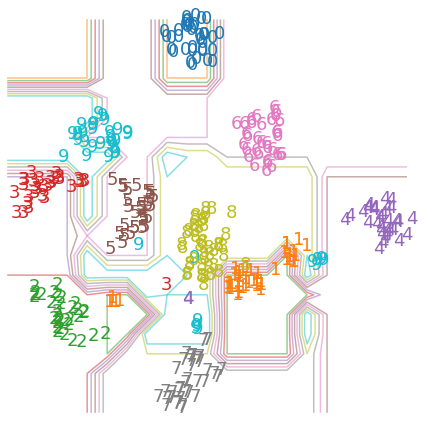

In [16]:
# Visualize the decision boundary
xMin, xMax = Xemb[:, 0].min(), Xemb[:, 0].max() + 0.05
yMin, yMax = Xemb[:, 1].min(), Xemb[:, 1].max() + 0.05
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
zMesh = search.best_estimator_.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
zMesh = zMesh.reshape(xMesh.shape) * 1.0
# boundary = ax.contourf(xMesh, yMesh, zMesh, np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
#                        cmap=plt.cm.tab10, alpha=0.15)
boundary = ax.contour(xMesh, yMesh, zMesh, np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), cmap=plt.cm.tab10, alpha=0.5)
    
for i in range(X.shape[0]):
    if np.random.ranf() < 0.8:
        # Skip some data points so that the image isn't super cluttered
        continue
    plt.text(Xemb[i, 0], Xemb[i, 1], str(y[i]), color=plt.cm.tab10(y[i] / 10.),
             fontdict={'size': 18})

ax.axis('off')
# fig.colorbar(boundary)

fig.tight_layout()
# plt.savefig('./figures/CH04_F15_Kunapuli.png', format='png', dpi=200, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH04_F15_Kunapuli.pdf', format='pdf', dpi=200, bbox_inches='tight', pad_inches=0)